# Classification 3. EPAM DS course

    author: Oleg Naidovich

In [ ]:
# !pip install pyspark
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm
# !pip install hyperopt

In [869]:
import pandas as pd
import numpy as np

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
%matplotlib inline


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import warnings
warnings.filterwarnings("ignore")

In [7]:
from pyspark.sql import SparkSession

# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
id_map = sqlContext.read.parquet('data/id_map.parquet')

In [8]:
df = pd.read_csv("data/train.csv", parse_dates=[f'time{i+1}' for i in range(10)])

In [9]:
df.head()

,session_id,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,...,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
0,0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,...,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,...,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,...,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,...,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


# EDA

First of all we should make some really needable things like deleting useless data (Nans), convert data to another format and so on. 

`update :D:`
I have realized that deleting data is really worse thing, so it is better to save them and add another feature, whick will say how much nans we have in dataframe


In [10]:
df.isna().sum() / df.shape[0] * 100

session_id    0.000000
webpage1      0.000000
time1         0.000000
webpage2      1.237115
time2         1.237115
webpage3      2.439848
time3         2.439848
webpage4      3.480049
time4         3.480049
webpage5      4.455863
time5         4.455863
webpage6      5.404172
time6         5.404172
webpage7      6.286843
time7         6.286843
webpage8      7.123255
time8         7.123255
webpage9      8.007176
time9         8.007176
webpage10     8.822334
time10        8.822334
target        0.000000
dtype: float64

In [11]:
df.describe()

,session_id,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,target
count,159969.000000,159969.000000,157990.000000,156066.000000,154402.000000,152841.000000,151324.000000,149912.000000,148574.000000,147160.000000,145856.000000,159969.000000
mean,79984.000000,44362.540573,44593.501722,45025.879231,45448.173081,45663.769584,45820.414706,46410.833809,46813.332925,46971.420053,47558.884736,0.009846
std,46179.216943,97167.414738,97682.859444,97995.435761,98488.571326,98504.193709,98600.684290,99314.768320,99651.347793,99794.332873,100488.244994,0.098736
min,0.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,0.000000
25%,39992.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,0.000000
50%,79984.000000,8160.000000,8160.000000,8173.000000,8238.000000,8693.000000,8810.000000,8940.000000,8953.000000,8953.000000,8953.000000,0.000000
75%,119976.000000,30845.000000,30663.000000,31508.000000,31716.000000,31716.000000,31963.000000,32704.000000,33809.000000,33835.000000,34108.000000,0.000000
max,159968.000000,540965.000000,540952.000000,540939.000000,540939.000000,540939.000000,540952.000000,540952.000000,540965.000000,540965.000000,540965.000000,1.000000


In [12]:
df.drop(columns="session_id", inplace=True)

In [13]:
df.drop(index=df[df.isna().any(axis=1)].index, inplace=True)

In [14]:
df.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,...,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,...,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,...,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,...,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,...,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0
5,48252,2019-02-20 12:04:13,3129.0,2019-02-20 12:05:08,7562.0,2019-02-20 12:05:08,425.0,2019-02-20 12:05:08,3129.0,2019-02-20 12:05:24,...,2019-02-20 12:05:24,425.0,2019-02-20 12:05:29,425.0,2019-02-20 12:05:39,30520.0,2019-02-20 12:05:40,26724.0,2019-02-20 12:05:40,0


* Lets get from data columns some info and then we will delete them all as all data time columns are the same. 

In [15]:
dates = [f'time{i+1}' for i in range(10)]

In [16]:
df["time_on_website"] = (df[dates[9]] - df[dates[0]]).apply(lambda x: x.seconds)

<AxesSubplot:xlabel='target', ylabel='time_on_website'>

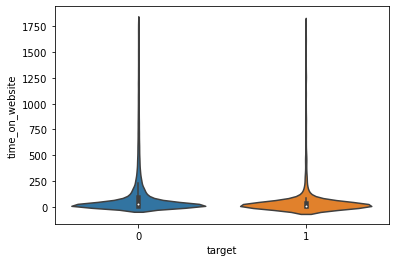

In [17]:
sns.violinplot(x="target", y="time_on_website" ,data=df)

In [18]:
ides = df[df.time_on_website > 500].index
def temp(x):
    if x in ides:
        return "more"
    else:
        return "less"

In [19]:
df["more_less"] = df["time_on_website"].apply(lambda x: temp(x))

In [20]:
df[df.target == 1].more_less.value_counts()[1] / df[df.target == 1].more_less.value_counts()[0] * 100

2.5165562913907285

In [21]:
df[df.target == 0].more_less.value_counts()[1] / df[df.target == 0].more_less.value_counts()[0] * 100

3.399898253835185

(-100.0, 500.0)

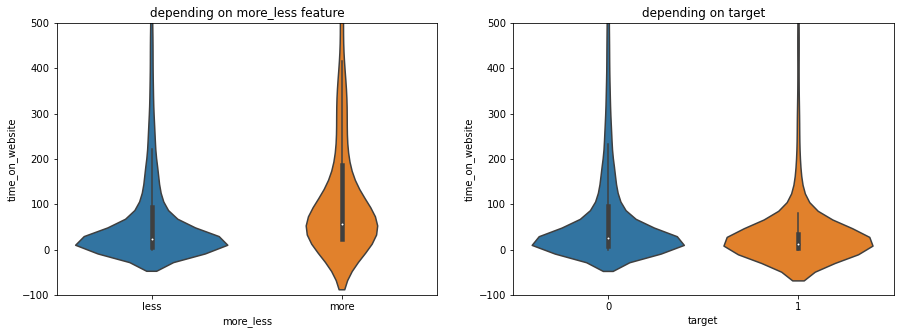

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

sns.violinplot(x="more_less", y="time_on_website" , data=df, ax=axs[0]).set_title('depending on more_less feature')
sns.violinplot(x="target", y="time_on_website" , data=df, ax=axs[1]).set_title('depending on target')
axs[0].set_ylim([-100, 500])
axs[1].set_ylim([-100, 500])


As we can see time features have correlation with target value. It is not strong but at least it exists.

In [23]:
df["main_date"] = df[dates[0]]

In [24]:
df.drop(columns=dates, inplace=True)

In [25]:
def to_hour_gaps(i):
    if i in range(0, 6):
        return "night"
    elif i in range(6,12):
        return "morning"
    elif i in range(12, 18):
        return "afternoon"
    else:
        return "evening"

df["Time"] = df["main_date"].dt.hour.map(to_hour_gaps)
df["Month"] = df['main_date'].dt.month_name()
df["Year"] = df['main_date'].apply(lambda x: int(x.year))
df.drop(columns="main_date", inplace=True)

# Pipeline

## Download data

In [810]:
def save_submission(pred):
    pd.Series(pred, name="target", index=pd.Index(range(len(pred)), name="session_id")).to_csv("submission.csv")

In [811]:
# download all data

train = pd.read_csv("data/train.csv", index_col=0, parse_dates=[f"time{i+1}" for i in range(10)])
test = pd.read_csv("data/test.csv", index_col=0, parse_dates=[f"time{i+1}" for i in range(10)])

from pyspark.sql import SparkSession

# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
id_map = sqlContext.read.parquet('data/id_map.parquet')
id_map = id_map.toPandas()

In [812]:
# !pip install tldextract

In [813]:
import tldextract

def get_domain(url):
    return tldextract.extract(url).domain

# seperate domain name
id_map["domain"] = id_map.webpage.apply(lambda x: get_domain(x))

# get dict from series
dict_of_domains = id_map[["id", "domain"]].set_index('id').to_dict()["domain"]
dict_of_domains

{326127: 'abmecatronique',
 182113: 'live',
 551820: 'wordpress',
 401995: 'tourinsoft',
 105504: 'hdwallpapers',
 487535: 'imageshack',
 71158: 'free',
 460677: 'ugent',
 392115: 'kissanime',
 497636: 'carolineconduiteformation',
 567485: 'mystockphoto',
 480619: 'csphares',
 532307: 'uqo',
 160650: 'cloudfront',
 403451: 'elong',
 404634: 'blogspot',
 366297: 'pages-annuaire',
 414553: 'pagesperso-orange',
 404062: 'forbes',
 168346: 'cedexis-radar',
 546178: 'cedexis-radar',
 73875: 'pacajob',
 417114: 'epfl',
 92504: 'cedexis',
 25359: 'akamaihd',
 87356: 'mystere-tv',
 566809: 'mon-ip',
 588285: 'aqua-passion',
 210687: 'la1ere',
 311125: 'kognitio',
 369989: 'calvin-thomas',
 183959: 'cedexis-radar',
 92218: 'allin1convert',
 599205: 'cedexis-radar',
 33939: 'lemonde',
 602143: 'programme',
 277299: 'ilatumi',
 42818: 'canalblog',
 593394: 'wordpress',
 374136: 'e-monsite',
 71015: 'cesi',
 80557: 'bugz',
 623801: 'cedexis-radar',
 409652: 'fanextra',
 609345: 'cedexis-radar',
 5

## Pipeline #0 

This is the best approach.

the features: 
1. 

In [842]:
def evaluate_model(classifier, train_set, train_target, test_set, test_target, metrics=[roc_auc_score]):
    prediction = train_model(classifier, train_set, train_target, test_set)
    results = get_model_metrics(classifier.__class__.__name__, test_target, prediction, metrics=[roc_auc_score])
    return results


def train_model(classifier, train_set, train_target, test_set):
    classifier.fit(train_set, train_target)
    return classifier.predict_proba(test_set)


def get_model_metrics(classifier_name, test_target, prediction, metrics=[roc_auc_score]):
    mectrics_result = dict()
    for metric in metrics:
        score = metric(test_target, prediction[:, 1])
        print("{} for model {} = {:.3f}".format(metric.__name__, classifier_name, score))
        mectrics_result[metric.__name__] = score
    mectrics_result['classifier'] = classifier_name
    return mectrics_result


In [843]:

def split_frame(dataframe):
    X = dataframe.drop(columns='target')
    y = dataframe.target.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test


def prepare_data(df):
    webpages = [f"webpage{i+1}" for i in range(10)]
    times = [f'time{i+1}' for i in range(10)]
    
    df =  (
        df.assign(
            hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),
            day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
            month=lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1),
            year=lambda x: x.filter(like='time').apply(lambda x: x.dt.year).mean(axis=1),
            nans_count=lambda x: x.isna().sum(axis=1).div(2),
            n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
            time_on_website=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
        ).drop(columns=times).fillna(0)
    )
    return df


In [856]:
df = train.copy()

In [857]:
df = prepare_data(df)

In [898]:
test = prepare_data(test)

In [859]:
X_train, X_test, y_train, y_test = split_frame(df)

In [ ]:
# for final train
X = df.drop(columns="target")
y = df.target

### Random Forest 

In [860]:
rf = RandomForestClassifier(random_state=42)
result_dict = evaluate_model(rf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

roc_auc_score for model RandomForestClassifier = 0.990


0.9898035702385588

In [853]:
# dont do this

param_grid = {
    'max_depth': [5, 10, None],
    'max_features': [2, 3, 'auto'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 6, 12],
    'n_estimators': [10, 100, 300]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

%%time
grid_search.fit(X_train, y_train)

### XGBoost

In [865]:
xg_clf = XGBClassifier(objective ='binary:logistic', random_state=42)
result_dict= evaluate_model(xg_clf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

[17:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc_score for model XGBClassifier = 0.996


0.9960337252107826

Nice score, but lets `tune` our model

In [870]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[17:50:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:02:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:15:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:26:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC 0.993 params {'colsample_bytree': '0.924', 'learning_rate': '0.286', 'alpha': '0.955', 'n_estimators': 1000}
[18:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric 

In [871]:
best

{'alpha': 1.1162532902346367,
 'colsample_bytree': 0.41177583242737537,
 'learning_rate': 0.2684542391692044,
 'n_estimators': 1}

In [872]:
best_xg_clf = XGBClassifier(objective ='binary:logistic', 
                            alpha=best['alpha'],
                            colsample_bytree = best['colsample_bytree'],
                            learning_rate=best['learning_rate'],
                            n_estimators=1000,
                            random_state=42)

result_dict = evaluate_model(best_xg_clf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

[18:33:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc_score for model XGBClassifier = 0.995


0.9951403388254298

In [901]:
y_pred = best_xg_clf.predict_proba(test)[:, 1]

In [903]:
save_submission(y_pred)

In [ ]:
best_xg_clf.fit(X, y, )

### LGBMClassifier

In [873]:
lgb_clf = LGBMClassifier(n_estimators=1000, random_state=42)

result_dict = evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

roc_auc_score for model LGBMClassifier = 0.994


0.9935258297896008

In [874]:
lgb_clf = LGBMClassifier(n_estimators=1000, 
                         num_leaves=7
                         ,random_state=42)

result_dict = evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

roc_auc_score for model LGBMClassifier = 0.994


0.9937711477785345

### CatBoost

In [877]:
cat_clf = CatBoostClassifier(random_state=42, verbose=False)


result_dict = evaluate_model(cat_clf, X_train, y_train, X_test, y_test)
result_dict["roc_auc_score"]

roc_auc_score for model CatBoostClassifier = 0.996


0.9963973930955212

In [885]:
cat_features = ['webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6',
       'webpage7', 'webpage8', 'webpage9', 'webpage10',
       'hour', 'day', 'nans_count', 'month', 'year']

In [888]:
cat_clf_mine = CatBoostClassifier(random_state=42, verbose=False)
cat_clf_mine.fit(X, y)

In [904]:
y_pred = cat_clf_mine.predict_proba(test)[:, 1]

In [905]:
save_submission(y_pred)

In [893]:
cat_clf_mine

## Pipeline #1

### Stratagy of preprocessing

Preproc function is our "pipeline". As we are going to use Boosting models (cat boost), our main goal is to reveal all information from dataframe like:

`numerical`
* time on website
* number of nans in data 
* number of uniqucal pages 


`categorical`
* when the person get on website
* what is the day (monday, ...)
* pages, where he stay (with real names, 10 features)
* year,  (it is not a numerical feature, it is more like nominal feauture)

In [479]:
def to_hour_gaps(i):
    if i in range(0, 6):
        return "night"
    elif i in range(6, 12):
        return "morning"
    elif i in range(12, 18):
        return "afternoon"
    else:
        return "evening"

def to_day_gaps(i):
    if i == 0:
        return "monday"
    elif i == 1:
        return "thursday"
    elif i == 2:
        return "wednesday"
    elif i == 3: 
        return "thursday"
    elif i == 4: 
        return "friday"
    elif i == 5:
        return "saturday"
    else:
        return "sunday"
        
        
def split_data(df):
    y = df.target
    X = df.drop(columns="target")
    return X, y

def preproc(df, dict_of_domains):
    webpages = [f"webpage{i+1}" for i in range(10)]
    times = [f'time{i+1}' for i in range(10)]
    
    df = (
        df.assign(
            n_unique_pages=lambda x: x.filter(like='webpage').apply(
                lambda row: row.nunique(), axis=1),
            hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).map(to_hour_gaps),
            day=lambda x: x.filter(like='time').apply(
                lambda x: x.dt.dayofweek).mean(axis=1).map(to_day_gaps),
            time_on_website=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            nans_count=lambda x: x.isna().sum(axis=1).div(2),  # time & webpage => div(2)
            month=lambda x: x.time1.dt.month_name(),
            year=lambda x: x.time1.apply(lambda y: y.year)
        ).drop(columns=times).fillna(0.)
    )
    
#     df = df.fillna(0.0)
    df[webpages] = df[webpages].astype("int64")
    for i in webpages:
        df[i] = df[i].replace(dict_of_domains)
        
    cat = list(X.columns.drop(["n_unique_pages", "time_on_website", "nans_count"]))
    X[cat] = X[cat].astype("category")
#     df[webpages] = df[webpages].replace(dict_of_domains) # replace with numbers of webpages with cat data
    
    return df.fillna(0)

In [650]:
X, y = split_data(train)
X = preproc(X, dict_of_domains)

In [651]:
test = preproc(test, dict_of_domains)
test

### Boosting methods

As the main goal is to win this competition, the best way to do this is to use boosting methods :D 
I will try `catboost` as it can work with categorical features

In [675]:
model_catBoost = CatBoostClassifier()
cat = list(X.columns.drop(["n_unique_pages", "time_on_website", "nans_count"]))

In [676]:
model_catBoost.fit(X, y, cat_features=cat)
# Get predictions

Learning rate set to 0.089962
0:	learn: 0.5083903	total: 219ms	remaining: 3m 38s
1:	learn: 0.3761709	total: 324ms	remaining: 2m 41s
2:	learn: 0.2755293	total: 369ms	remaining: 2m 2s
3:	learn: 0.2105681	total: 542ms	remaining: 2m 14s
4:	learn: 0.1688232	total: 610ms	remaining: 2m 1s
5:	learn: 0.1363476	total: 725ms	remaining: 2m
6:	learn: 0.1154866	total: 761ms	remaining: 1m 47s
7:	learn: 0.0961636	total: 979ms	remaining: 2m 1s
8:	learn: 0.0817814	total: 1.21s	remaining: 2m 13s
9:	learn: 0.0705584	total: 1.45s	remaining: 2m 23s
10:	learn: 0.0611283	total: 1.64s	remaining: 2m 27s
11:	learn: 0.0537141	total: 1.83s	remaining: 2m 30s
12:	learn: 0.0489187	total: 2.04s	remaining: 2m 35s
13:	learn: 0.0445921	total: 2.3s	remaining: 2m 42s
14:	learn: 0.0411660	total: 2.59s	remaining: 2m 50s
15:	learn: 0.0378857	total: 2.89s	remaining: 2m 57s
16:	learn: 0.0360947	total: 3.22s	remaining: 3m 6s
17:	learn: 0.0347931	total: 3.46s	remaining: 3m 8s
18:	learn: 0.0334944	total: 3.81s	remaining: 3m 16s
19

157:	learn: 0.0181174	total: 44.3s	remaining: 3m 56s
158:	learn: 0.0181139	total: 44.6s	remaining: 3m 56s
159:	learn: 0.0180619	total: 45s	remaining: 3m 56s
160:	learn: 0.0180595	total: 45.2s	remaining: 3m 55s
161:	learn: 0.0180513	total: 45.6s	remaining: 3m 55s
162:	learn: 0.0180342	total: 45.9s	remaining: 3m 55s
163:	learn: 0.0180288	total: 46.2s	remaining: 3m 55s
164:	learn: 0.0179811	total: 46.5s	remaining: 3m 55s
165:	learn: 0.0179761	total: 46.8s	remaining: 3m 55s
166:	learn: 0.0179266	total: 47.1s	remaining: 3m 55s
167:	learn: 0.0179049	total: 47.5s	remaining: 3m 55s
168:	learn: 0.0178915	total: 47.8s	remaining: 3m 55s
169:	learn: 0.0178611	total: 48.1s	remaining: 3m 55s
170:	learn: 0.0178475	total: 48.5s	remaining: 3m 55s
171:	learn: 0.0178427	total: 48.8s	remaining: 3m 54s
172:	learn: 0.0178385	total: 48.9s	remaining: 3m 53s
173:	learn: 0.0177726	total: 49.3s	remaining: 3m 53s
174:	learn: 0.0177482	total: 49.6s	remaining: 3m 54s
175:	learn: 0.0177350	total: 50s	remaining: 3m 5

311:	learn: 0.0159054	total: 1m 34s	remaining: 3m 27s
312:	learn: 0.0158998	total: 1m 34s	remaining: 3m 27s
313:	learn: 0.0158955	total: 1m 34s	remaining: 3m 27s
314:	learn: 0.0158886	total: 1m 35s	remaining: 3m 27s
315:	learn: 0.0158844	total: 1m 35s	remaining: 3m 27s
316:	learn: 0.0158691	total: 1m 35s	remaining: 3m 26s
317:	learn: 0.0158491	total: 1m 36s	remaining: 3m 26s
318:	learn: 0.0158456	total: 1m 36s	remaining: 3m 26s
319:	learn: 0.0158447	total: 1m 36s	remaining: 3m 25s
320:	learn: 0.0158332	total: 1m 37s	remaining: 3m 25s
321:	learn: 0.0158258	total: 1m 37s	remaining: 3m 25s
322:	learn: 0.0157972	total: 1m 37s	remaining: 3m 25s
323:	learn: 0.0157906	total: 1m 38s	remaining: 3m 25s
324:	learn: 0.0157640	total: 1m 38s	remaining: 3m 24s
325:	learn: 0.0157629	total: 1m 38s	remaining: 3m 24s
326:	learn: 0.0157445	total: 1m 39s	remaining: 3m 24s
327:	learn: 0.0157358	total: 1m 39s	remaining: 3m 24s
328:	learn: 0.0157274	total: 1m 39s	remaining: 3m 23s
329:	learn: 0.0157258	total:

465:	learn: 0.0144500	total: 2m 26s	remaining: 2m 48s
466:	learn: 0.0144468	total: 2m 27s	remaining: 2m 47s
467:	learn: 0.0144437	total: 2m 27s	remaining: 2m 47s
468:	learn: 0.0144428	total: 2m 27s	remaining: 2m 47s
469:	learn: 0.0144379	total: 2m 28s	remaining: 2m 47s
470:	learn: 0.0144299	total: 2m 28s	remaining: 2m 46s
471:	learn: 0.0144285	total: 2m 28s	remaining: 2m 46s
472:	learn: 0.0144239	total: 2m 29s	remaining: 2m 46s
473:	learn: 0.0144197	total: 2m 29s	remaining: 2m 45s
474:	learn: 0.0144169	total: 2m 29s	remaining: 2m 45s
475:	learn: 0.0144112	total: 2m 30s	remaining: 2m 45s
476:	learn: 0.0144033	total: 2m 30s	remaining: 2m 45s
477:	learn: 0.0143892	total: 2m 30s	remaining: 2m 44s
478:	learn: 0.0143880	total: 2m 31s	remaining: 2m 44s
479:	learn: 0.0143847	total: 2m 31s	remaining: 2m 44s
480:	learn: 0.0143790	total: 2m 32s	remaining: 2m 44s
481:	learn: 0.0143779	total: 2m 32s	remaining: 2m 43s
482:	learn: 0.0143691	total: 2m 32s	remaining: 2m 43s
483:	learn: 0.0143610	total:

618:	learn: 0.0135785	total: 3m 19s	remaining: 2m 2s
619:	learn: 0.0135756	total: 3m 19s	remaining: 2m 2s
620:	learn: 0.0135719	total: 3m 19s	remaining: 2m 1s
621:	learn: 0.0135700	total: 3m 20s	remaining: 2m 1s
622:	learn: 0.0135677	total: 3m 20s	remaining: 2m 1s
623:	learn: 0.0135528	total: 3m 20s	remaining: 2m
624:	learn: 0.0135507	total: 3m 21s	remaining: 2m
625:	learn: 0.0135414	total: 3m 21s	remaining: 2m
626:	learn: 0.0135381	total: 3m 21s	remaining: 1m 59s
627:	learn: 0.0135378	total: 3m 21s	remaining: 1m 59s
628:	learn: 0.0135366	total: 3m 22s	remaining: 1m 59s
629:	learn: 0.0135357	total: 3m 22s	remaining: 1m 59s
630:	learn: 0.0135148	total: 3m 22s	remaining: 1m 58s
631:	learn: 0.0135120	total: 3m 23s	remaining: 1m 58s
632:	learn: 0.0134989	total: 3m 23s	remaining: 1m 58s
633:	learn: 0.0134978	total: 3m 23s	remaining: 1m 57s
634:	learn: 0.0134933	total: 3m 24s	remaining: 1m 57s
635:	learn: 0.0134897	total: 3m 24s	remaining: 1m 57s
636:	learn: 0.0134849	total: 3m 24s	remaining

771:	learn: 0.0125416	total: 4m 10s	remaining: 1m 14s
772:	learn: 0.0125412	total: 4m 11s	remaining: 1m 13s
773:	learn: 0.0125369	total: 4m 11s	remaining: 1m 13s
774:	learn: 0.0125290	total: 4m 12s	remaining: 1m 13s
775:	learn: 0.0124951	total: 4m 12s	remaining: 1m 12s
776:	learn: 0.0124867	total: 4m 12s	remaining: 1m 12s
777:	learn: 0.0124843	total: 4m 13s	remaining: 1m 12s
778:	learn: 0.0124796	total: 4m 13s	remaining: 1m 11s
779:	learn: 0.0124698	total: 4m 13s	remaining: 1m 11s
780:	learn: 0.0124664	total: 4m 14s	remaining: 1m 11s
781:	learn: 0.0124647	total: 4m 14s	remaining: 1m 10s
782:	learn: 0.0124474	total: 4m 15s	remaining: 1m 10s
783:	learn: 0.0124458	total: 4m 15s	remaining: 1m 10s
784:	learn: 0.0124380	total: 4m 15s	remaining: 1m 10s
785:	learn: 0.0124368	total: 4m 16s	remaining: 1m 9s
786:	learn: 0.0124084	total: 4m 16s	remaining: 1m 9s
787:	learn: 0.0124054	total: 4m 16s	remaining: 1m 9s
788:	learn: 0.0123989	total: 4m 17s	remaining: 1m 8s
789:	learn: 0.0123782	total: 4m 

927:	learn: 0.0115754	total: 5m 6s	remaining: 23.7s
928:	learn: 0.0115692	total: 5m 6s	remaining: 23.4s
929:	learn: 0.0115588	total: 5m 6s	remaining: 23.1s
930:	learn: 0.0115578	total: 5m 7s	remaining: 22.8s
931:	learn: 0.0115514	total: 5m 7s	remaining: 22.4s
932:	learn: 0.0115246	total: 5m 7s	remaining: 22.1s
933:	learn: 0.0115219	total: 5m 8s	remaining: 21.8s
934:	learn: 0.0115194	total: 5m 8s	remaining: 21.4s
935:	learn: 0.0115188	total: 5m 8s	remaining: 21.1s
936:	learn: 0.0115153	total: 5m 9s	remaining: 20.8s
937:	learn: 0.0115108	total: 5m 9s	remaining: 20.5s
938:	learn: 0.0115008	total: 5m 9s	remaining: 20.1s
939:	learn: 0.0114949	total: 5m 10s	remaining: 19.8s
940:	learn: 0.0114940	total: 5m 10s	remaining: 19.5s
941:	learn: 0.0114764	total: 5m 10s	remaining: 19.1s
942:	learn: 0.0114715	total: 5m 11s	remaining: 18.8s
943:	learn: 0.0114705	total: 5m 11s	remaining: 18.5s
944:	learn: 0.0114698	total: 5m 12s	remaining: 18.2s
945:	learn: 0.0114681	total: 5m 12s	remaining: 17.8s
946:	

In [683]:
print(roc_auc_score(y, model_catBoost.predict_proba(X)[:, 1]))

0.9975722244569549


Nice score, but we nead more!

In [684]:
y_pred = model_catBoost.predict_proba(test)[:, 1]
save_submission(y_pred)

## Pipeline #2

There i will test cat boost with the same features, but i will not transform them into categorical status.

In [ ]:
def preproc(df):
    webpages = [f"webpage{i+1}" for i in range(10)]

    df =  (
        df.assign(
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
            nans_count=lambda x: x.isna().sum(axis=1).div(2), # time & webpage => div(2)
            n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
            
        ).drop(columns=[f'time{i+1}' for i in range(10)]).fillna(0)
    )
    return df


In [ ]:
temp_train = pd.read_csv("data/train.csv", index_col=0, parse_dates=[f"time{i+1}" for i in range(10)])
temp_test = pd.read_csv("data/test.csv", index_col=0, parse_dates=[f"time{i+1}" for i in range(10)])

In [744]:
temp_target = temp_train.target
temp_train = temp_train.drop(columns="target")

In [745]:
temp_train = preproc(temp_train)
temp_test = preproc(temp_test)

In [782]:
webpages = [f"webpage{i+1}" for i in range(10)]

In [757]:
temp_train[webpages] = temp_train[webpages].astype("category") 
temp_test[webpages] = temp_test[webpages].astype("category") 

In [785]:
for i in webpages[1:]:
    temp_train[i] = temp_train[i].map(str)
    temp_test[i] = temp_test[i].map(str)


In [787]:
clf_catBoost = CatBoostClassifier(cat_features=webpages)

In [789]:
clf_catBoost.fit(temp_train, temp_target, cat_features=webpages)

Learning rate set to 0.089962
0:	learn: 0.5063992	total: 238ms	remaining: 3m 57s
1:	learn: 0.3609535	total: 468ms	remaining: 3m 53s
2:	learn: 0.2728683	total: 719ms	remaining: 3m 58s
3:	learn: 0.2107624	total: 915ms	remaining: 3m 47s
4:	learn: 0.1529906	total: 1.11s	remaining: 3m 40s
5:	learn: 0.1250245	total: 1.27s	remaining: 3m 31s
6:	learn: 0.1056647	total: 1.39s	remaining: 3m 17s
7:	learn: 0.0921284	total: 1.58s	remaining: 3m 16s
8:	learn: 0.0754759	total: 1.79s	remaining: 3m 17s
9:	learn: 0.0644058	total: 1.96s	remaining: 3m 13s
10:	learn: 0.0571801	total: 2.17s	remaining: 3m 14s
11:	learn: 0.0519015	total: 2.43s	remaining: 3m 20s
12:	learn: 0.0473252	total: 2.66s	remaining: 3m 22s
13:	learn: 0.0437251	total: 2.84s	remaining: 3m 20s
14:	learn: 0.0407140	total: 3.07s	remaining: 3m 21s
15:	learn: 0.0385777	total: 3.26s	remaining: 3m 20s
16:	learn: 0.0370529	total: 3.56s	remaining: 3m 26s
17:	learn: 0.0358421	total: 3.84s	remaining: 3m 29s
18:	learn: 0.0348075	total: 4.05s	remaining:

158:	learn: 0.0203536	total: 35.1s	remaining: 3m 5s
159:	learn: 0.0203085	total: 35.4s	remaining: 3m 5s
160:	learn: 0.0202817	total: 35.6s	remaining: 3m 5s
161:	learn: 0.0202453	total: 35.8s	remaining: 3m 5s
162:	learn: 0.0201528	total: 36.1s	remaining: 3m 5s
163:	learn: 0.0201348	total: 36.3s	remaining: 3m 4s
164:	learn: 0.0201161	total: 36.5s	remaining: 3m 4s
165:	learn: 0.0201028	total: 36.7s	remaining: 3m 4s
166:	learn: 0.0200677	total: 37s	remaining: 3m 4s
167:	learn: 0.0200541	total: 37.2s	remaining: 3m 4s
168:	learn: 0.0200438	total: 37.4s	remaining: 3m 4s
169:	learn: 0.0200055	total: 37.6s	remaining: 3m 3s
170:	learn: 0.0199924	total: 37.8s	remaining: 3m 3s
171:	learn: 0.0199645	total: 38.1s	remaining: 3m 3s
172:	learn: 0.0199497	total: 38.3s	remaining: 3m 3s
173:	learn: 0.0199414	total: 38.5s	remaining: 3m 2s
174:	learn: 0.0199051	total: 38.7s	remaining: 3m 2s
175:	learn: 0.0199036	total: 38.8s	remaining: 3m 1s
176:	learn: 0.0197598	total: 39.1s	remaining: 3m 1s
177:	learn: 0.

315:	learn: 0.0175242	total: 1m 14s	remaining: 2m 41s
316:	learn: 0.0175180	total: 1m 14s	remaining: 2m 41s
317:	learn: 0.0174871	total: 1m 15s	remaining: 2m 41s
318:	learn: 0.0174785	total: 1m 15s	remaining: 2m 41s
319:	learn: 0.0174739	total: 1m 15s	remaining: 2m 40s
320:	learn: 0.0174624	total: 1m 15s	remaining: 2m 40s
321:	learn: 0.0174483	total: 1m 16s	remaining: 2m 40s
322:	learn: 0.0174404	total: 1m 16s	remaining: 2m 40s
323:	learn: 0.0174283	total: 1m 16s	remaining: 2m 40s
324:	learn: 0.0174133	total: 1m 17s	remaining: 2m 40s
325:	learn: 0.0174083	total: 1m 17s	remaining: 2m 39s
326:	learn: 0.0173601	total: 1m 17s	remaining: 2m 39s
327:	learn: 0.0173493	total: 1m 17s	remaining: 2m 39s
328:	learn: 0.0173258	total: 1m 18s	remaining: 2m 39s
329:	learn: 0.0173087	total: 1m 18s	remaining: 2m 39s
330:	learn: 0.0173025	total: 1m 18s	remaining: 2m 39s
331:	learn: 0.0172983	total: 1m 19s	remaining: 2m 39s
332:	learn: 0.0172821	total: 1m 19s	remaining: 2m 38s
333:	learn: 0.0172419	total:

467:	learn: 0.0157474	total: 1m 54s	remaining: 2m 9s
468:	learn: 0.0157451	total: 1m 54s	remaining: 2m 9s
469:	learn: 0.0157379	total: 1m 54s	remaining: 2m 9s
470:	learn: 0.0157338	total: 1m 54s	remaining: 2m 8s
471:	learn: 0.0157283	total: 1m 55s	remaining: 2m 8s
472:	learn: 0.0157242	total: 1m 55s	remaining: 2m 8s
473:	learn: 0.0157182	total: 1m 55s	remaining: 2m 8s
474:	learn: 0.0157166	total: 1m 55s	remaining: 2m 8s
475:	learn: 0.0156877	total: 1m 56s	remaining: 2m 8s
476:	learn: 0.0156829	total: 1m 56s	remaining: 2m 7s
477:	learn: 0.0156820	total: 1m 56s	remaining: 2m 7s
478:	learn: 0.0156787	total: 1m 57s	remaining: 2m 7s
479:	learn: 0.0156615	total: 1m 57s	remaining: 2m 7s
480:	learn: 0.0156525	total: 1m 57s	remaining: 2m 6s
481:	learn: 0.0156468	total: 1m 57s	remaining: 2m 6s
482:	learn: 0.0156421	total: 1m 58s	remaining: 2m 6s
483:	learn: 0.0156411	total: 1m 58s	remaining: 2m 6s
484:	learn: 0.0156286	total: 1m 58s	remaining: 2m 5s
485:	learn: 0.0156252	total: 1m 58s	remaining:

621:	learn: 0.0144148	total: 2m 38s	remaining: 1m 36s
622:	learn: 0.0144084	total: 2m 38s	remaining: 1m 35s
623:	learn: 0.0144039	total: 2m 38s	remaining: 1m 35s
624:	learn: 0.0144001	total: 2m 39s	remaining: 1m 35s
625:	learn: 0.0143981	total: 2m 39s	remaining: 1m 35s
626:	learn: 0.0143939	total: 2m 39s	remaining: 1m 35s
627:	learn: 0.0143882	total: 2m 40s	remaining: 1m 34s
628:	learn: 0.0143668	total: 2m 40s	remaining: 1m 34s
629:	learn: 0.0143628	total: 2m 40s	remaining: 1m 34s
630:	learn: 0.0143573	total: 2m 40s	remaining: 1m 34s
631:	learn: 0.0143506	total: 2m 41s	remaining: 1m 33s
632:	learn: 0.0143263	total: 2m 41s	remaining: 1m 33s
633:	learn: 0.0143252	total: 2m 41s	remaining: 1m 33s
634:	learn: 0.0143224	total: 2m 42s	remaining: 1m 33s
635:	learn: 0.0143196	total: 2m 42s	remaining: 1m 32s
636:	learn: 0.0143159	total: 2m 42s	remaining: 1m 32s
637:	learn: 0.0142987	total: 2m 43s	remaining: 1m 32s
638:	learn: 0.0142848	total: 2m 43s	remaining: 1m 32s
639:	learn: 0.0142837	total:

775:	learn: 0.0133876	total: 3m 24s	remaining: 59.1s
776:	learn: 0.0133869	total: 3m 25s	remaining: 58.9s
777:	learn: 0.0133850	total: 3m 25s	remaining: 58.7s
778:	learn: 0.0133617	total: 3m 25s	remaining: 58.4s
779:	learn: 0.0133576	total: 3m 26s	remaining: 58.2s
780:	learn: 0.0133214	total: 3m 26s	remaining: 57.9s
781:	learn: 0.0133197	total: 3m 26s	remaining: 57.7s
782:	learn: 0.0133187	total: 3m 27s	remaining: 57.5s
783:	learn: 0.0133084	total: 3m 27s	remaining: 57.2s
784:	learn: 0.0133032	total: 3m 28s	remaining: 57s
785:	learn: 0.0133004	total: 3m 28s	remaining: 56.7s
786:	learn: 0.0132772	total: 3m 28s	remaining: 56.5s
787:	learn: 0.0132757	total: 3m 28s	remaining: 56.2s
788:	learn: 0.0132744	total: 3m 29s	remaining: 55.9s
789:	learn: 0.0132723	total: 3m 29s	remaining: 55.6s
790:	learn: 0.0132627	total: 3m 29s	remaining: 55.4s
791:	learn: 0.0132602	total: 3m 29s	remaining: 55.1s
792:	learn: 0.0132453	total: 3m 30s	remaining: 54.9s
793:	learn: 0.0132368	total: 3m 30s	remaining: 5

931:	learn: 0.0124407	total: 4m 14s	remaining: 18.6s
932:	learn: 0.0124397	total: 4m 14s	remaining: 18.3s
933:	learn: 0.0124371	total: 4m 14s	remaining: 18s
934:	learn: 0.0124307	total: 4m 15s	remaining: 17.7s
935:	learn: 0.0124182	total: 4m 15s	remaining: 17.5s
936:	learn: 0.0124092	total: 4m 15s	remaining: 17.2s
937:	learn: 0.0124030	total: 4m 16s	remaining: 16.9s
938:	learn: 0.0123940	total: 4m 16s	remaining: 16.7s
939:	learn: 0.0123835	total: 4m 16s	remaining: 16.4s
940:	learn: 0.0123796	total: 4m 17s	remaining: 16.1s
941:	learn: 0.0123778	total: 4m 17s	remaining: 15.9s
942:	learn: 0.0123692	total: 4m 17s	remaining: 15.6s
943:	learn: 0.0123555	total: 4m 18s	remaining: 15.3s
944:	learn: 0.0123522	total: 4m 18s	remaining: 15.1s
945:	learn: 0.0123475	total: 4m 18s	remaining: 14.8s
946:	learn: 0.0123470	total: 4m 19s	remaining: 14.5s
947:	learn: 0.0123414	total: 4m 19s	remaining: 14.2s
948:	learn: 0.0123393	total: 4m 19s	remaining: 14s
949:	learn: 0.0123267	total: 4m 20s	remaining: 13.

In [790]:
y_pred = clf_catBoost.predict_proba(temp_test)[:, 1]

In [ ]:
print(roc_auc_score(temp_target clf_catBoost.predict_proba(temp_train)[:, 1]))

In [792]:
save_submission(y_pred)

As we can see, the score is almost the same. It is really interesting that it is not necessary for catboost to get numerical features (which is categorical for real) and process it as well as others. -_- 

## Pipeline #3

It is the first and the worst approach that I have. For real I cannot remember what I have done there ^_^

I was trying to test random forest approach, which gave me real big score but it is not enough.  

There I will try to process data with sklearn pipeline, lest see what we will get.

In [43]:
test = pd.read_csv("data/test.csv")

In [46]:
ohe = ['more_less', 'Time', 'Month', 'year']

ohe_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore', ))
])


scaler_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler_pipeline, ["time_on_website"]),
        ('ohe', ohe_pipeline, ohe)
    ]
)

In [47]:
LogisticRegression_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classify', LogisticRegression(n_jobs=-1))
    ]
)

In [48]:
RandomForestClassifier_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classify', RandomForestClassifier(n_estimators=135))
    ]
)

In [49]:
X = df.drop(columns="target")
y = df.target

In [51]:
clf = LogisticRegression_pipeline.fit(X, y)

In [494]:
accuracy_score(clf.predict(X), y)

0.9893867924528302

In [520]:
LogisticRegression_pipeline.named_steps["classify"]

LogisticRegression(n_jobs=-1)

In [477]:
kfold = KFold(n_splits=5)

In [478]:
cross_val_score(LogisticRegression_pipeline, X, y, cv=kfold, n_jobs=-1)

array([0.9891677 , 0.9888588 , 0.98930445, 0.99091564, 0.9886874 ])

In [483]:
cross_val_score(RandomForestClassifier_pipeline, X, y, cv=kfold, n_jobs=-1)

array([0.9891677 , 0.98930445, 0.98964725, 0.99046999, 0.9886874 ])

Year, score is high but it is lower than in the boosting methods. It is bad.

### sklearn pipeline

It was really bad idea to build my own pipeline there) 

In [15]:
dates = [f'time{i}' for i in range(1,11)]


['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [16]:
test_data = pd.read_csv("data/test.csv", parse_dates=dates, na_values=np.nan)

In [17]:
test_data.head()

,session_id,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,...,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10
0,0,10318,2019-03-28 06:47:12,10318.0,2019-03-28 06:47:42,10318.0,2019-03-28 06:48:12,10318.0,2019-03-28 06:48:42,10318.0,...,10318.0,2019-03-28 06:49:42,10318.0,2019-03-28 06:50:12,10318.0,2019-03-28 06:50:42,10318.0,2019-03-28 06:51:12,10318.0,2019-03-28 06:51:42
1,1,438,2019-02-28 06:48:05,2453.0,2019-02-28 06:50:22,2427.0,2019-02-28 06:50:22,2466.0,2019-02-28 06:50:23,2453.0,...,2466.0,2019-02-28 06:50:59,2427.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:52:06,2466.0,2019-02-28 06:52:11
2,2,7562,2019-03-18 11:13:31,425.0,2019-03-18 11:13:39,7562.0,2019-03-18 11:18:02,425.0,2019-03-18 11:18:43,425.0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
3,3,8836,2019-03-17 12:18:08,12372.0,2019-03-17 12:18:35,12398.0,2019-03-17 12:18:35,12385.0,2019-03-17 12:18:35,12385.0,...,12398.0,2019-03-17 12:18:36,12372.0,2019-03-17 12:18:36,451.0,2019-03-17 12:18:52,425.0,2019-03-17 12:18:52,438.0,2019-03-17 12:18:53
4,4,451,2019-03-31 09:46:43,9863.0,2019-03-31 09:46:44,451.0,2019-03-31 09:46:46,9889.0,2019-03-31 09:46:46,451.0,...,425.0,2019-03-31 09:47:46,9928.0,2019-03-31 09:49:43,867.0,2019-03-31 10:05:12,880.0,2019-03-31 10:05:12,867.0,2019-03-31 10:05:13


In [37]:
# class FeautureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, feature_names):
#         self.feature_names = feature_names

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         return X[self.feature_names]

def to_hour_gaps(i):
    if i in range(0, 6):
        return "night"
    elif i in range(6, 12):
        return "morning"
    elif i in range(12, 18):
        return "afternoon"
    else:
        return "evening"


class Transformator_ohe(BaseEstimator, TransformerMixin):
    def __init__(self):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        This func should return clear X. (year, month, time)
        """

        data = X.copy()

        main_date = X.time1
        data["Time"] = main_date.dt.hour.map(to_hour_gaps)
        data["Month"] = main_date.dt.month_name()
        data["Year"] = main_date.apply(lambda x: x.year)
        data.drop(columns=X.columns, inplace=True)

        return data


class Transformator_ss(BaseEstimator, TransformerMixin):
    def __init__(self):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)

    def fit(self, X, y=None):
        return self

    def is_date(x):
        return isinstance(x, pd._libs.tslibs.nattype.NaTType)

    def transform(self, X, y=None):
        """
        This func should return (time_on_website)
        """

        data = X.copy()

#         for key, value in enumerate(data.time10):
#             if is_date(i):
#                 data.time10[key] = data.time1[key]

        data["time10"] = data["time10"].fillna(value=data["time1"])
        data["Time_on_website"] = (
            data.time10 - data.time1).apply(lambda x: x.seconds)
        data.drop(columns=X.columns, inplace=True)

        return data

In [32]:
preprocessor_date_ohe = Pipeline([
    ("transformator", Transformator_ohe()),
    ("ohe", OneHotEncoder())
])

preprocessor_date_ss = Pipeline([
    ("transformator", Transformator_ss()),
    ("ohe", RobustScaler(quantile_range=(0.0,75.0)))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('date_ohe', preprocessor_date_ohe, ["time1"]),
        ('date_ss', preprocessor_date_ss, ["time1", "time10"])
    ]
)


In [33]:
logistic_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(n_jobs=-1))
])

In [34]:
train_data = pd.read_csv("epamdscourseclassification3/train.csv", parse_dates=dates)
train_data.drop(index=train_data[train_data.isna().any(axis=1)].index, inplace=True)

In [35]:
X_train = train_data.drop(columns="target")
y_train = train_data.target

In [38]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('date_ohe',
                                                  Pipeline(steps=[('transformator',
                                                                   Transformator_ohe()),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['time1']),
                                                 ('date_ss',
                                                  Pipeline(steps=[('transformator',
                                                                   Transformator_ss()),
                                                                  ('ohe',
                                                                   RobustScaler(quantile_range=(0.0,
                                                                                                75.0)

In [913]:
cross_val_score(logistic_pipeline, X, y, cv=kfold, n_jobs=-1, scoring="roc_auc")

array([0.85571327, 0.87117535, 0.85330812, 0.8615275 , 0.8560854 ])

In [39]:
model = logistic_pipeline.fit(X_train, y_train)

In [40]:
y_pred_train = model.predict_proba(X_train)

In [45]:
roc_auc_score(y_train, model.predict(X_train))

0.5

In [920]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    145856
           1       0.00      0.00      0.00         0

    accuracy                           0.99    145856
   macro avg       0.50      0.49      0.50    145856
weighted avg       1.00      0.99      0.99    145856



C:\Users\Oleg-Nai\anaconda3\envs\course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oleg-Nai\anaconda3\envs\course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Oleg-Nai\anaconda3\envs\course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
y_pred = model.predict_proba(test_data)

In [54]:
y_pred[:, 1]

array([0.00017348, 0.00314337, 0.00037583, ..., 0.00037583, 0.00579059,
       0.00132634])

In [907]:
pd.Series(data=y_pred, name = "target").to_csv("save.csv")

In [55]:
save_submission(y_pred[:, 1])

In [941]:
RFC_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier())
])

In [802]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

parameters_RFC = {'clf__n_estimators': [100, 200, 50, 500],
               'clf__max_features': ['auto', 'sqrt'],
               'clf__max_depth': [3,5,7,10],
                 }

In [1]:
grid_search_RFC = GridSearchCV(estimator=RFC_pipeline,
                                   param_grid=parameters_RFC, cv=kfold, scoring='roc_auc', n_jobs=-1)

NameError: name 'GridSearchCV' is not defined

In [ ]:
grid_search_RFC.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
GBC_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", GradientBoostingClassifier())
])

In [ ]:
parameters_GBC = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
                "clf__criterion": ["friedman_mse",  "mae"],
              "clf__loss":["deviance","exponential"],
              "clf__max_features":["log2","sqrt"],
              'clf__learning_rate': [0.01,0.05,0.1,1,0.5], #so called `eta` value
              'clf__max_depth': [3,4,5],
              'clf__min_samples_leaf': [4,5,6],

              'clf__subsample': [0.6,0.7,0.8],
              'clf__n_estimators': [5,10,15,20]#number of trees, change it to 1000 for better result}

In [ ]:
grid_search_GBC = GridSearchCV(estimator=GBC_pipeline,
                                   param_grid=parameters_GBC, cv=kfold, scoring='roc_auc', n_jobs=-1)

In [ ]:
grid_search_GBC.fit(X_train, y_train)

## Pipeline #4 

There i have used grid search woth second pipeline.

In [100]:
train = pd.read_csv("data/train.csv", index_col=0, parse_dates=[f"time{i}" for i in range(1,11)])
test = pd.read_csv("data/test.csv", index_col=0, parse_dates=[f"time{i}" for i in range(1,11)])

In [101]:
test.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10
session_id,,,,,,,,,,,,,,,,,,,,
0,10318,2019-03-28 06:47:12,10318.0,2019-03-28 06:47:42,10318.0,2019-03-28 06:48:12,10318.0,2019-03-28 06:48:42,10318.0,2019-03-28 06:49:12,10318.0,2019-03-28 06:49:42,10318.0,2019-03-28 06:50:12,10318.0,2019-03-28 06:50:42,10318.0,2019-03-28 06:51:12,10318.0,2019-03-28 06:51:42
1,438,2019-02-28 06:48:05,2453.0,2019-02-28 06:50:22,2427.0,2019-02-28 06:50:22,2466.0,2019-02-28 06:50:23,2453.0,2019-02-28 06:50:23,2466.0,2019-02-28 06:50:59,2427.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:50:59,2453.0,2019-02-28 06:52:06,2466.0,2019-02-28 06:52:11
2,7562,2019-03-18 11:13:31,425.0,2019-03-18 11:13:39,7562.0,2019-03-18 11:18:02,425.0,2019-03-18 11:18:43,425.0,2019-03-18 11:24:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
3,8836,2019-03-17 12:18:08,12372.0,2019-03-17 12:18:35,12398.0,2019-03-17 12:18:35,12385.0,2019-03-17 12:18:35,12385.0,2019-03-17 12:18:36,12398.0,2019-03-17 12:18:36,12372.0,2019-03-17 12:18:36,451.0,2019-03-17 12:18:52,425.0,2019-03-17 12:18:52,438.0,2019-03-17 12:18:53
4,451,2019-03-31 09:46:43,9863.0,2019-03-31 09:46:44,451.0,2019-03-31 09:46:46,9889.0,2019-03-31 09:46:46,451.0,2019-03-31 09:47:45,425.0,2019-03-31 09:47:46,9928.0,2019-03-31 09:49:43,867.0,2019-03-31 10:05:12,880.0,2019-03-31 10:05:12,867.0,2019-03-31 10:05:13


In [102]:
train.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,...,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,...,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,...,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,...,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,...,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


In [103]:
target = train.target
train = train.drop(columns="target")

In [135]:
train.filter(like="webpage").apply(lambda x: x.nunique(), axis=1)

session_id
0         1
1         7
2         4
3         7
4         7
         ..
159964    5
159965    5
159966    6
159967    3
159968    6
Length: 159969, dtype: int64

In [402]:
def preproc(df):
    df =  (
        df.assign(
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            nans_count=lambda x: x.isna().sum(axis=1).div(2), # time & webpage => div(2)
            n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
            
            avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).map(to_hour_gaps),
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).map(to_day_gaps),
        ).drop(columns=[f'time{i+1}' for i in range(10)]).fillna(0.)
    )
    return df
    

In [404]:
temp = preproc(temp)

In [405]:
temp

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,target,first_last_diff,nans_count,n_unique_pages,avg_hour,avg_day
session_id,,,,,,,,,,,,,,,,
0,9486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,9.0,1,night,wednesday
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,0,26.0,0.0,7,morning,friday
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,0,7.0,0.0,4,afternoon,sunday
3,10591,451.0,77580.0,227821.0,633.0,425.0,10591.0,227834.0,227834.0,227834.0,0,102.0,0.0,7,afternoon,wednesday
4,438,425.0,529.0,65685.0,187638.0,451.0,425.0,65685.0,187625.0,187625.0,0,6.0,0.0,7,morning,thursday


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier()

parameters_RFC = {'n_estimators': [100, 200, 50, 500, 130],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [3,5,7,10],
                 }


In [72]:
grod = GridSearchCV(clf, param_grid=parameters_RFC, n_jobs=-1, cv=KFold(n_splits=5),)

In [73]:
grod.fit(train, target)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 50, 500, 130]})

In [98]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, max_features="sqrt", n_jobs=-1)

In [99]:
clf.fit(train, target)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=200,
                       n_jobs=-1)

In [81]:
clf = grod.best_estimator_

In [83]:
grod.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=200)

In [97]:
grod.best_estimator_.predict(test)

IndexError: list index out of range

In [100]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(target, clf.predict_proba(train)[:, 1]))

0.9965678514101227


In [102]:
pred = clf.predict_proba(test)[:, 1]
save_submission(pred)

In [929]:
a = [12,312,3]
b = [324,234,23]

In [932]:
t = a + b

In [933]:
t.sort()

In [934]:
t

array([151.5, 362.5, 452.5])

In [923]:
np.median([nums1, nums2])

array([  6. , 156. ,   1.5, 162. , 117. ,  11.5,   2. ])